In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [2]:
dataset = np.load('/kaggle/input/continuous-stirred-tank-reactor-domain-adaptation/cstr_rawdata.npy')

In [3]:
dataset.shape

(2860, 1404)

In [4]:
X = dataset[:, :-4]
class_label = dataset[:, -4]
domain_label = dataset[:, -3]
parameter_noise = dataset[:, -2]
reaction_order = dataset[:, -1]

In [5]:
dataset

array([[0.99971876, 0.99985421, 1.000517  , ..., 0.        , 0.        ,
        1.        ],
       [1.0024113 , 1.00082024, 1.00099968, ..., 0.        , 0.        ,
        1.        ],
       [0.99919657, 0.99892216, 1.00009477, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.99907708, 1.00136615, 1.00001701, ..., 6.        , 0.15      ,
        2.        ],
       [1.00109772, 1.00021364, 1.00017934, ..., 6.        , 0.15      ,
        2.        ],
       [1.00089225, 1.00021464, 1.00033901, ..., 6.        , 0.15      ,
        2.        ]])

## Exploring domains

In [6]:
np.unique(domain_label, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6.]),
 array([1300,  260,  260,  260,  260,  260,  260]))

There are 1300 (100x per fault + 100x for normal operation) samples in the source domain (i.e. reaction order $N = 1$ and parameter noise $\epsilon= 0.0$). Next, we explore the other domains.

In [7]:
np.unique(reaction_order, return_counts=True)

(array([0.5, 1. , 1.5, 2. ]), array([ 260, 2080,  260,  260]))

There are 4 types of reaction order: 0.5, 1.0, 1.5, and 2.0. This corresponds to the velocity of the reaction $A \rightarrow B$. Each target domain (i.e., a specific combination of $N$ and parameter noise $\epsilon$) has 260 samples (20x samples for each fault + 20x samples for normal operation). There are 4 domains with $N = 1$, i.e., the source domain (which has $N = 1.0$ and $\epsilon = 0.0$), and $N = 1.0$ with $\epsilon \in \{0.1, 0.15, 0.2\}$.

In [8]:
np.unique(parameter_noise, return_counts=True)

(array([0.  , 0.1 , 0.15, 0.2 ]), array([1300,  260, 1040,  260]))

we now list the combination $(N, \epsilon)$ for each domain label,

In [9]:
print('-' * 49)
print("|{:^15}|{:^15}|{:^15}|".format('Domain Label', "N", "ϵ"))
print('-' * 49)
for domain in np.unique(domain_label):
    ind = np.where(domain_label == domain)[0]
    print("|{:^15}|{:^15}|{:^15}|".format(domain, np.unique(reaction_order[ind]).item(), np.unique(parameter_noise[ind]).item()))
print('-' * 49)

-------------------------------------------------
| Domain Label  |       N       |       ϵ       |
-------------------------------------------------
|      0.0      |      1.0      |      0.0      |
|      1.0      |      1.0      |      0.1      |
|      2.0      |      1.0      |     0.15      |
|      3.0      |      1.0      |      0.2      |
|      4.0      |      0.5      |     0.15      |
|      5.0      |      1.5      |     0.15      |
|      6.0      |      2.0      |     0.15      |
-------------------------------------------------


## t-SNE Visualisation of raw signals

### Source Domain

The feature matrix $X$ is composed by the concatenation of raw signals. There are 7 measured variables, measured through 200min with a sampling rate of 1min. As such, $X \in \mathbb{R}^{2860 \times 1400}$,

In [10]:
X.shape

(2860, 1400)

in this section, let us analyze the signals coming from the source domain. We need to filter the rows of $X$ by $domain\_label:=0$

In [11]:
ind_s = np.where(domain_label == 0)[0]
Xs = X[ind_s]
ys = class_label[ind_s]

this now gives us a matrix $X_{s} \in \mathbb{R}^{1300 \times 1400}$.

In [12]:
ys

array([ 0.,  0.,  0., ..., 12., 12., 12.])

In [13]:
Xs.shape

(1300, 1400)

we can now investigate the signals in $X_{s}$. Let us show a few variables for the normal operation,

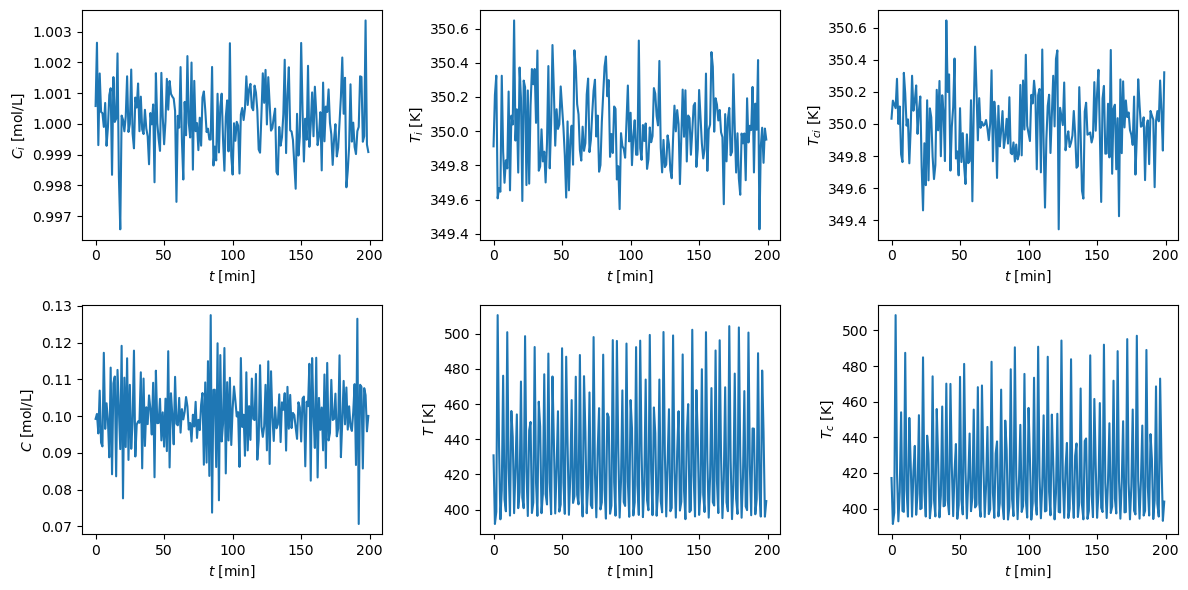

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

t = np.arange(0, 200, 1)

axes[0, 0].plot(t, Xs[-1, :200])
axes[0, 0].set_ylabel('$C_{i}$ [mol/L]')
axes[0, 0].set_xlabel('$t$ [min]')

axes[0, 1].plot(t, Xs[-1, 200:400])
axes[0, 1].set_ylabel('$T_{i}$ [K]')
axes[0, 1].set_xlabel('$t$ [min]')

axes[0, 2].plot(t, Xs[-1, 400:600])
axes[0, 2].set_ylabel('$T_{ci}$ [K]')
axes[0, 2].set_xlabel('$t$ [min]')

axes[1, 0].plot(t, Xs[-1, 600: 800])
axes[1, 0].set_ylabel('$C$ [mol/L]')
axes[1, 0].set_xlabel('$t$ [min]')

axes[1, 1].plot(t, X[-1, 800: 1000])
axes[1, 1].set_ylabel('$T$ [K]')
axes[1, 1].set_xlabel('$t$ [min]')

axes[1, 2].plot(t, X[-1, 1000: 1200])
axes[1, 2].set_ylabel('$T_{c}$ [K]')
axes[1, 2].set_xlabel('$t$ [min]')

plt.tight_layout()

now, for fault 1,

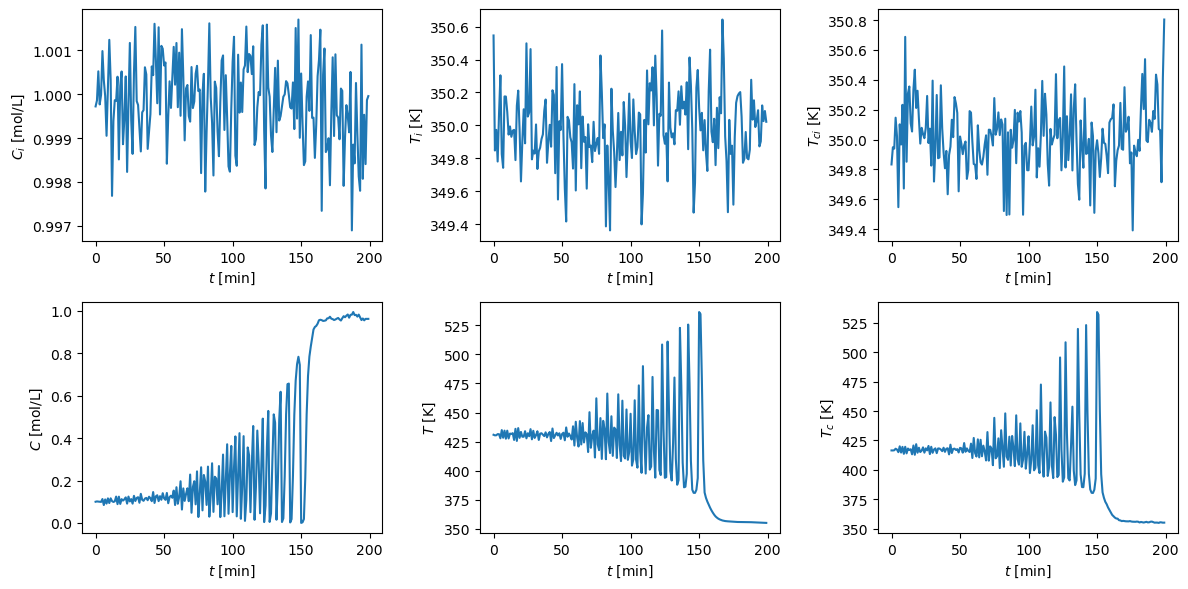

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

t = np.arange(0, 200, 1)

axes[0, 0].plot(t, Xs[0, :200])
axes[0, 0].set_ylabel('$C_{i}$ [mol/L]')
axes[0, 0].set_xlabel('$t$ [min]')

axes[0, 1].plot(t, Xs[0, 200:400])
axes[0, 1].set_ylabel('$T_{i}$ [K]')
axes[0, 1].set_xlabel('$t$ [min]')

axes[0, 2].plot(t, Xs[0, 400:600])
axes[0, 2].set_ylabel('$T_{ci}$ [K]')
axes[0, 2].set_xlabel('$t$ [min]')

axes[1, 0].plot(t, Xs[0, 600: 800])
axes[1, 0].set_ylabel('$C$ [mol/L]')
axes[1, 0].set_xlabel('$t$ [min]')

axes[1, 1].plot(t, X[0, 800: 1000])
axes[1, 1].set_ylabel('$T$ [K]')
axes[1, 1].set_xlabel('$t$ [min]')

axes[1, 2].plot(t, X[0, 1000: 1200])
axes[1, 2].set_ylabel('$T_{c}$ [K]')
axes[1, 2].set_xlabel('$t$ [min]')

plt.tight_layout()

as you may see, the signals are quite different. Also, their range is different. We thus need to normalize them before applying t-SNE. We normalize each variable independently,

In [16]:
signals = [Xs[:, i * 200: (i + 1) * 200] for i in range(7)]

for signal in signals:
    print(signal.shape)

(1300, 200)
(1300, 200)
(1300, 200)
(1300, 200)
(1300, 200)
(1300, 200)
(1300, 200)


In [17]:
for i in range(len(signals)):
    μ, σ = signals[i].mean(), signals[i].std()
    
    signals[i] = (signals[i] - μ) / σ
Xs = np.concatenate(signals, axis=1)

In [18]:
Xs.shape

(1300, 1400)

now that all signals are standardized, we can visualize them in $\mathbb{R}^{2}$ using t-SNE.

In [19]:
tsne = TSNE(n_components=2)

In [20]:
proj = tsne.fit_transform(Xs)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(-55.841640090942384,
 52.78645668029785,
 -53.805726051330566,
 58.56865406036377)

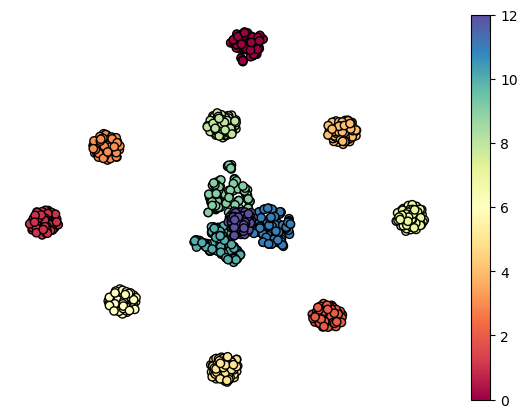

In [21]:
plt.figure(figsize=(7, 5))
sca = plt.scatter(proj[:, 0], proj[:, 1], c=ys, cmap=plt.get_cmap('Spectral'), edgecolor='k')
plt.colorbar(sca)
plt.axis('off')

As we can see, classes are well separated in the source domain. A few classes are confused, such as class $13$ (i.e. normal operation), $11$ and $10$. This is further discussed in [1] and [2].

### t-SNE visualization of different domains

We apply the same preprocessing steps for the target domain data.

In [22]:
Xt, yt = [], []
for domain in np.unique(domain_label).astype(int)[1:]:
    ind_t = np.where(domain_label == domain)[0]
    Xtk = X[ind_t]
    ytk = class_label[ind_t]
    signals = [Xtk[:, i * 200: (i + 1) * 200] for i in range(7)]

    for i in range(len(signals)):
        μ, σ = signals[i].mean(), signals[i].std()

        signals[i] = (signals[i] - μ) / σ
    Xtk = np.concatenate(signals, axis=1)
    Xt.append(Xtk)
    yt.append(ytk)

In [23]:
all_features = np.concatenate([Xs] + Xt, axis=0)
all_labels = np.concatenate([ys] + yt, axis=0)

In [24]:
proj = tsne.fit_transform(all_features)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


next, we show the t-SNE visualization. Note that here, colors represent domains rather than classes.

(-61.06419296264649, 65.99950332641602, -66.66244640350342, 71.59969081878663)

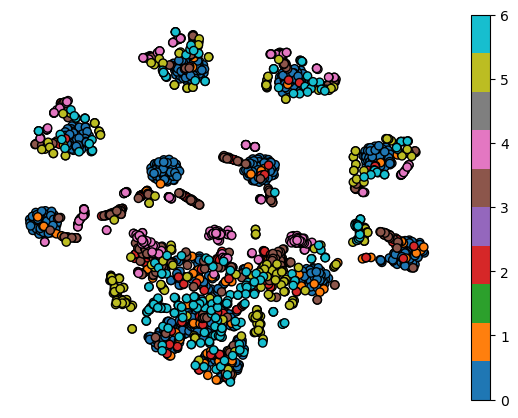

In [25]:
plt.figure(figsize=(7, 5))
sca = plt.scatter(proj[:, 0], proj[:, 1], c=domain_label, cmap=plt.get_cmap('tab10'), edgecolor='k')
plt.colorbar(sca)
plt.axis('off')

as we can see, there is a significant different in distribution between data from multiple domains. An effort must be done in order to match these distributions, before applying a classifier learned with source domain data, on each of the target domains. For more information, see references [1] and [2].

## References

[1] Montesuma, E., 2021. Cross-Domain Fault Diagnosis through Optimal Transport. Bachelor dissertation. Universidade Federal do Ceará.

[2] Montesuma, E. F., Mulas, M., Corona, F., & Mboula, F. M. N. (2022). Cross-domain fault diagnosis through optimal transport for a CSTR process. IFAC-PapersOnLine, 55(7), 946-951.